🚗📷 — **Number Plate Recognition using OCR** is a **classic Computer Vision project**.
I’ll give you a **step-by-step roadmap** with explanation + code snippets so you can **teach or build it end-to-end**.

---

# 🚦 Project: Automatic Number Plate Recognition (ANPR) using OCR

---

## 🔹 Workflow

```text
Car Image/Video
        ↓
Preprocessing (grayscale, blur, edge detection)
        ↓
Find Contours → Locate License Plate Region
        ↓
Crop & Enhance License Plate
        ↓
OCR with PyTesseract
        ↓
Extracted Number Plate Text
```

---

## 🔹 Tools & Libraries

* **OpenCV** → Image processing (contours, edges).
* **PyTesseract** → OCR (text extraction).
* **Matplotlib** → Display images.
* **NumPy** → Array operations.

Install:

```bash
pip install opencv-python pytesseract matplotlib
```

👉 Also install **Tesseract OCR Engine**:

* Windows: Download from [Tesseract GitHub](https://github.com/UB-Mannheim/tesseract/wiki) and set path.

In [4]:
pip install opencv-python pytesseract matplotlib

## 🔹 Step-by-Step Implementation

In [5]:

### 1. Import Libraries
import cv2
import pytesseract
import matplotlib.pyplot as plt

# 👉 If on Windows, set Tesseract path:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"


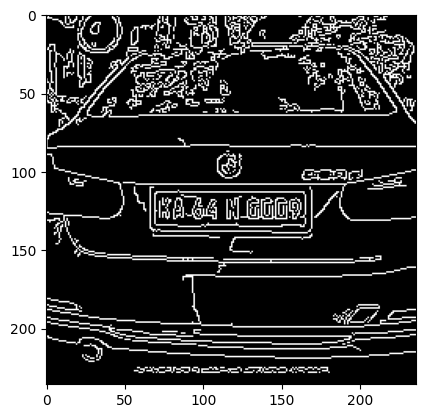

In [26]:
### 2. Load Image & Preprocess
# Load image
img = cv2.imread("car.jpg")
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Noise removal
blur = cv2.bilateralFilter(gray, 11, 17, 17)

# Edge detection
edges = cv2.Canny(blur, 10, 200)

plt.imshow(edges, cmap="gray")
plt.show()

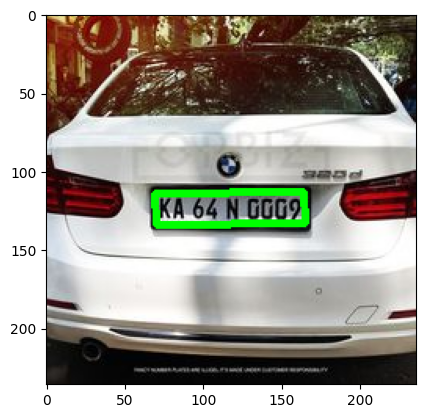

In [27]:

### 3. Find Contours (Locate Number Plate)

# Find contours
contours, _ = cv2.findContours(edges.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]

plate = None
for c in contours:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
    if len(approx) == 4:   # number plate = rectangle
        plate = approx
        break

# Draw plate region
cv2.drawContours(img, [plate], -1, (0,255,0), 3)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()



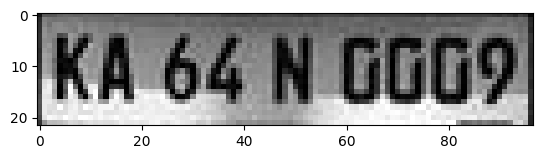

In [28]:
### 4. Mask & Crop Plate Region

mask = cv2.drawContours(cv2.cvtColor(gray, cv2.COLOR_GRAY2BGR), [plate], -1, (0,255,0), -1)
x, y, w, h = cv2.boundingRect(plate)
plate_img = gray[y:y+h, x:x+w]

plt.imshow(plate_img, cmap="gray")
plt.show()

In [29]:
### 5. OCR using PyTesseract

# Extract text
text = pytesseract.image_to_string(plate_img, config='--psm 8')
print("Detected Number Plate:", text.strip())

Detected Number Plate: KA 64 N GGG9)


## 🔹 Output Example

```
Detected Number Plate: DL 3C AX 2451
```

---

## 🔹 Improvements & Extensions

✅ Preprocessing → Adaptive thresholding & morphology to clean plate text.
✅ Deep Learning → Use **YOLO/SSD** models to detect plates in real time.
✅ Real-Time → Capture frames from webcam or CCTV feed.
✅ Multilingual OCR → Train Tesseract for different scripts (Hindi, Arabic, etc.).

---

## 📌 Assignment for Students

1. Run the above pipeline on **sample car images**.
2. Try saving the detected number plate in a **text file (CSV)**.
3. Extend to **video stream**: Detect number plate frame by frame and display text live.

---

👉 Do you want me to extend this into a **mini real-time ANPR system with OpenCV + webcam feed**, so you can **demo it live in class**?


Nice — below is a **ready-to-run, teacher-friendly real-time ANPR (Automatic Number Plate Recognition) script** that uses OpenCV + PyTesseract and the contour-detection approach. It:

* Captures video from your webcam (or a video file)
* Locates candidate rectangular regions (possible plates)
* Cleans & enhances the plate region
* Runs Tesseract OCR on the region
* Filters/normalizes the text and logs detected plates to a CSV
* Shows bounding boxes, detected text, and FPS on screen

Read the instructions and run the script as-is, then tweak thresholds if needed for your environment.

---

# 1) Install prerequisites

System-level: **Tesseract OCR** (engine)

* **Windows**: Download and install (suggested build: UB Mannheim). After install, note the full path to `tesseract.exe` (e.g. `C:\Program Files\Tesseract-OCR\tesseract.exe`).
* **Ubuntu/Debian**:

```bash
sudo apt update
sudo apt install tesseract-ocr
```

Python packages:

```bash
pip install opencv-python pytesseract imutils pandas
```

---

# 2) Full script — `realtime_anpr.py`

```python
"""
realtime_anpr.py
Real-time Number Plate Recognition (Webcam) using OpenCV + PyTesseract.

Notes:
- Make sure Tesseract is installed and accessible.
- On Windows, set pytesseract.pytesseract.tesseract_cmd to your tesseract.exe path.
"""

import cv2
import pytesseract
import imutils
import numpy as np
import time
import re
import pandas as pd
from datetime import datetime

# ---------- CONFIG ----------
# If on Windows, set this to your tesseract executable path, e.g.:
# pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
# On Linux/Mac usually not needed.
# pytesseract.pytesseract.tesseract_cmd = r"/usr/bin/tesseract"

# video_source = 0 for webcam, or provide path 'video.mp4'
VIDEO_SOURCE = 0

# Minimum contour area to consider (tweak depending on camera/distance)
MIN_CONTOUR_AREA = 2000

# CSV output for detected plate logs
OUTPUT_CSV = "detected_plates.csv"

# OCR config: treat image as a single line of text (--psm 7 or 8), OEM 3 (default LSTM/NN)
OCR_CONFIG = r'--oem 3 --psm 7 -c tessedit_char_whitelist=ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789- '

# Whether to show intermediate debug windows (set False for clean single-window view)
DEBUG_WINDOWS = False
# ----------------------------

# Helper: normalize extracted text by removing unwanted chars and keeping alphanumeric+dash
def normalize_plate_text(text):
    if text is None:
        return ""
    # uppercase, remove non alphanumeric and dash (keep space too)
    txt = text.upper()
    # replace common OCR mistakes
    txt = txt.replace(' ', '').replace('|', 'I')
    # keep letters, digits and dash
    txt = re.sub(r'[^A-Z0-9\-]', '', txt)
    return txt

# Helper: simple heuristic to test if string looks like a plate
def looks_like_plate(s):
    if not s or len(s) < 4:
        return False
    # must contain at least one digit and one letter
    has_digit = bool(re.search(r'\d', s))
    has_alpha = bool(re.search(r'[A-Z]', s))
    return has_digit and has_alpha

# Initialize CSV log if not exists
try:
    df_log = pd.read_csv(OUTPUT_CSV)
except Exception:
    df_log = pd.DataFrame(columns=["timestamp", "plate_text", "confidence", "bbox_x", "bbox_y", "bbox_w", "bbox_h"])

# Open video capture
cap = cv2.VideoCapture(VIDEO_SOURCE)
time.sleep(1.0)

prev_time = time.time()
fps = 0
frame_count = 0

while True:
    ret, frame = cap.read()
    if not ret:
        print("Frame not read — end of stream or camera not accessible.")
        break

    frame = imutils.resize(frame, width=900)  # keep frame manageable
    orig = frame.copy()
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Preprocessing: reduce noise while preserving edges
    blur = cv2.bilateralFilter(gray, 11, 17)  # effective for license plates
    edged = cv2.Canny(blur, 30, 200)

    # Find contours
    cnts = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)[:50]

    plate_candidates = []
    for c in cnts:
        area = cv2.contourArea(c)
        if area < MIN_CONTOUR_AREA:
            continue

        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # common heuristic: plate region is rectangular (4 points)
        if len(approx) == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h) if h > 0 else 0
            # typical license plate aspect ratio range - adjust depending on region
            if 2.0 <= aspect_ratio <= 7.0:
                plate_candidates.append((x, y, w, h, approx, area))

    detected_plate_text = None
    best_confidence = 0.0
    best_bbox = None

    # Process each candidate: crop, enhance and OCR
    for (x, y, w, h, approx, area) in plate_candidates:
        # expand bbox slightly to include margins
        pad_x = int(0.03 * w)
        pad_y = int(0.08 * h)
        x1 = max(x - pad_x, 0)
        y1 = max(y - pad_y, 0)
        x2 = min(x + w + pad_x, frame.shape[1])
        y2 = min(y + h + pad_y, frame.shape[0])
        plate_img = gray[y1:y2, x1:x2]

        # Further preprocessing for OCR
        # Resize up (helps OCR), apply adaptive threshold and morphological ops
        plate_img = cv2.resize(plate_img, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        plate_img = cv2.GaussianBlur(plate_img, (3, 3), 0)
        plate_img = cv2.adaptiveThreshold(plate_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 11, 2)
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        plate_img = cv2.morphologyEx(plate_img, cv2.MORPH_CLOSE, kernel)

        if DEBUG_WINDOWS:
            cv2.imshow("candidate_plate", plate_img)
            cv2.waitKey(1)

        # OCR
        ocr_result = pytesseract.image_to_data(plate_img, output_type=pytesseract.Output.DICT, config=OCR_CONFIG)
        text_pieces = []
        confidences = []
        for i, txt in enumerate(ocr_result['text']):
            if txt.strip() == "":
                continue
            conf = float(ocr_result['conf'][i]) if ocr_result['conf'][i].isdigit() or re.match(r'^\-?\d+(\.\d+)?$', str(ocr_result['conf'][i])) else -1
            text_pieces.append(txt)
            confidences.append(conf)

        # combine pieces naive way
        combined = " ".join(text_pieces).strip()
        combined_norm = normalize_plate_text(combined)

        avg_conf = np.mean([c for c in confidences if c >= 0]) if confidences else -1

        # Heuristic to pick best candidate: text that "looks like a plate" and has reasonable confidence
        if looks_like_plate(combined_norm):
            if avg_conf > best_confidence:
                best_confidence = avg_conf
                detected_plate_text = combined_norm
                best_bbox = (x1, y1, x2 - x1, y2 - y1)

    # If a plate was found, annotate and log
    if detected_plate_text:
        x, y, w, h = best_bbox
        cv2.rectangle(orig, (x, y), (x + w, y + h), (0, 255, 0), 2)
        label = f"{detected_plate_text} ({int(best_confidence) if best_confidence>=0 else 'NA'})"
        cv2.putText(orig, label, (x, y - 8), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        # log unique detections with timestamp (avoid duplicate logging if same recently)
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        # append to in-memory DataFrame
        new_row = {"timestamp": timestamp, "plate_text": detected_plate_text,
                   "confidence": float(best_confidence), "bbox_x": int(x), "bbox_y": int(y),
                   "bbox_w": int(w), "bbox_h": int(h)}
        df_log = df_log.append(new_row, ignore_index=True)
        # save CSV periodically (or every detection)
        try:
            df_log.to_csv(OUTPUT_CSV, index=False)
        except Exception as e:
            print("Failed to save CSV:", e)

    # Compute FPS
    frame_count += 1
    if frame_count >= 10:
        curr_time = time.time()
        fps = frame_count / (curr_time - prev_time)
        prev_time = curr_time
        frame_count = 0

    # Overlay FPS
    cv2.putText(orig, f"FPS: {fps:.1f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)

    cv2.imshow("ANPR - Press 'q' to quit", orig)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
# ensure csv saved at end
try:
    df_log.to_csv(OUTPUT_CSV, index=False)
    print(f"Saved detections to {OUTPUT_CSV}")
except Exception as e:
    print("Could not save CSV on exit:", e)
```

---

# 3) How to run

```bash
python realtime_anpr.py
```

If Tesseract is not in PATH (Windows), edit the script and add a line near the top:

```python
pytesseract.pytesseract.tesseract_cmd = r"C:\Program Files\Tesseract-OCR\tesseract.exe"
```

---

# 4) Tips to improve accuracy (teaching points)

1. **Lighting & resolution**: better lighting and close-up images help OCR accuracy. Resize plate crop up (we do fx=2) before OCR.
2. **Whitelist characters**: we configured Tesseract to only expect A-Z and 0-9 which reduces garbage. Adjust whitelist for region-specific characters.
3. **Better detection model**: contour heuristics are simple but fragile. For production or harder scenes, use an object detector (YOLOv5/YOLOv8, SSD or Faster R-CNN) trained to detect license plates — then pass detected boxes to OCR.
4. **Post-processing**: use regex templates for your country’s format to correct OCR mistakes (e.g., `([A-Z]{2}\d{1,2}[A-Z]{1,2}\d{1,4})` for some formats). Spell-correction style logic can fix common OCR confusions (0 ↔ O, 1 ↔ I, 8 ↔ B).
5. **Temporal smoothing** (video): track the plate across frames and aggregate OCR results across several frames — voting reduces false positives.
6. **Use Deep Learning OCR**: EasyOCR or commercial OCR may outperform Tesseract on small, noisy plate crops.

---

# 5) Classroom/demo ideas

* Demo live webcam: show original frame → detected bbox → OCR result printed and logged to CSV.
* Show intermediate steps (set `DEBUG_WINDOWS = True`) to display preprocessed plate candidate images.
* Exercise: students should run on different distances/angles and tune `MIN_CONTOUR_AREA` and aspect ratio constraints.
* Extension assignment: integrate a simple tracker (e.g., `cv2.TrackerKCF_create`) to avoid repeatedly OCRing the same plate every frame.

---

If you want, I can next:

* Provide a **YOLO-based** ANPR demo with pretrained YOLOv5/YOLOv8 model and inference script (better accuracy / production-ready), **OR**
* Create a **slide-ready lesson** (PowerPoint) summarizing the pipeline with images and code snippets for your class, **OR**
* Add a **post-processing regex** tailored for Indian license plates (RTO formats) and show how to correct common OCR errors.

Which of those would you like me to produce now?
